Short plan (what I am planning to do)

* Reproject detections to a metric CRS
 (important: clustering uses distances). Use local UTM or Web Mercator (EPSG:3857) for rough work; for precise distances use a local projected CRS.
* Quick exploratory plots & KDE heatmap to see scale(s) of clustering visually.
* Run density-based clustering (HDBSCAN and DBSCAN) to find clusters without requiring tessellation.
* Run point-pattern tests (Ripley’s K / L) to identify scales where clustering departs from Complete Spatial Randomness (CSR).
* Aggregate to a regular grid (hex or square) and compute counts per cell; then run local spatial statistics (Local Moran’s I and Getis-Ord Gi*) to detect hotspots and coldspots.
*Export cluster labels and hotspot layers to GeoPackage and inspect in QGIS; iterate parameters.

-  Why these choices? (pros/cons)

**HDBSCAN** — density-based, finds clusters of varying density, robust to noise, minimal parameter tuning (min_cluster_size). Good when clusters vary in density.
**DBSCAN** — simpler, needs eps and min_samples; good for uniform-density clusters but sensitive to eps.
**Ripley’s K / L and G/F functions** — give scale-dependent tests (do points cluster at 50 m? 200 m?), but are global tests (K) or cumulative; use to pick scales for clustering or spatial windows.
**KDE (kernel density)** — continuous intensity surface; great for visualization and deriving hotspots. Bandwidth matters.
**Local Moran’s I and Getis-Ord Gi\*** — require area-based attributes (counts/density per cell). Converting points to grid counts enables these tests; they provide local significance and are common in GIS (QGIS has tools).
R’s spatstat is the gold standard for point-pattern stats (Ripley K, envelope tests) — more mature than Python for some PP analyses.
PySAL (libpysal + esda + pointpats) provides local/global spatial stats in Python and integrates with geopandas.

## Tools & libraries

### Python:
geopandas (read/write GeoPackage, basic geodata)
pyproj (CRS transforms, built into geopandas)
scikit-learn (DBSCAN)
hdbscan (HDBSCAN clustering)
PySAL ecosystem: libpysal, esda, pointpats (spatial weights, Local Moran, Getis-Ord, point-pattern utilities)
scipy / numpy / matplotlib / contextily (background tiles)
scikit-learn or sklearn.neighbors.KernelDensity (KDE) or use scipy

### R:
spatstat (point pattern analysis, Ripley K, L, G, F, envelope tests)
dbscan (HDBSCAN/DBSCAN)
sf (spatial data I/O)
### QGIS:
Heatmap plugin / Kernel Density
Hotspot Analysis (Getis-Ord Gi*) via Processing providers (SAGA, GRASS or native tools)
"Cluster and outlier analysis (Local Moran's I)" via SAGA/Hotspot Processing

In [4]:
!%pip install geopandas numpy matplotlib contextily scikit-learn hdbscan libpysal esda pointpats scipy

zsh:fg:1: no job control in this shell.


In [5]:
import geopandas as gpd
import numpy as np
'''
Load detections and prepare point coordinates for clustering.
This cell will reproject features to EPSG:2193 (NZTM) and compute
representative points when geometries are not Points. It also
drops null geometries and reports diagnostics.
'''
# adjust path: notebook is in Cluster_Analysis/ so ../detections.gpkg points to imagery/detections.gpkg
gdf = gpd.read_file('../detections.gpkg', layer='detections')
# drop null/empty geometries
gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
print('Original features (after drop):', len(gdf))
# reproject to EPSG:2193 (NZTM) as requested
gdf_m = gdf.to_crs(epsg=2193)
# report geometry types
geom_types = gdf_m.geom_type.unique().tolist()
print('Geometry types in layer:', geom_types)
# compute representative points if not all Points
if all(t == 'Point' for t in geom_types):
    pts = gdf_m.geometry
else:
    try:
        pts = gdf_m.geometry.representative_point()
    except Exception:
        pts = gdf_m.geometry.centroid
# drop invalid
valid_mask = pts.notnull()
if not valid_mask.all():
    print(f'Dropping {len(pts) - valid_mask.sum()} invalid geometries')
    gdf_m = gdf_m[valid_mask].copy()
    pts = pts[valid_mask]
# assemble coords array (in meters)
coords = np.vstack([pts.x.values, pts.y.values]).T
print('Prepared coords shape:', coords.shape)
# store representative points on GeoDataFrame for later use/export
gdf_m['rep_point'] = pts
# create a point GeoDataFrame for export: drop the original geometry column
gdf_points = gdf_m.drop(columns='geometry').set_geometry('rep_point').copy()
# write out a small GeoPackage for inspection
out = '../detections_analysis.gpkg'
try:
    gdf_points.to_file(out, layer='detections_points_2193', driver='GPKG', mode='w')
    print('Wrote representative points to', out, 'layer detections_points_2193')
except Exception as e:
    print('Failed to write points GeoPackage:', e)


Original features (after drop): 4209
Geometry types in layer: ['Polygon']
Prepared coords shape: (4209, 2)
Wrote representative points to ../detections_analysis.gpkg layer detections_points_2193


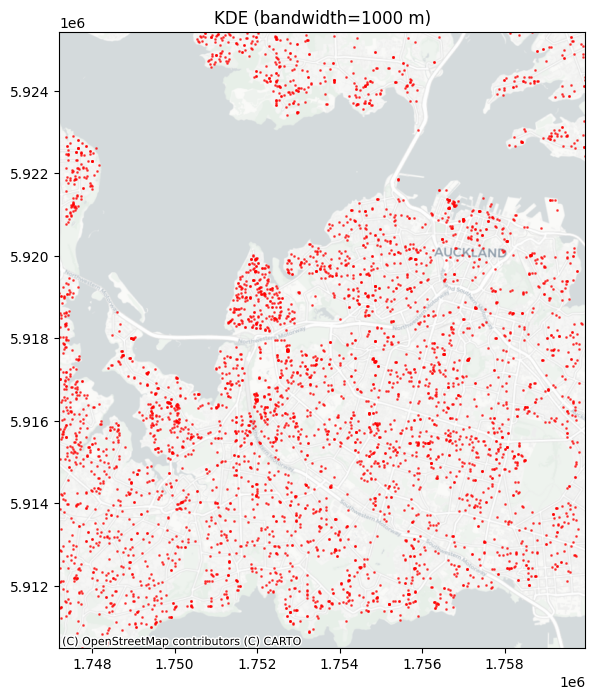

In [6]:
'''
Quick KDE Heatmap Visualization (visual intuition for bandwidth selection
Use the KDE plots to pick a scale where hotspots appear — useful to set eps for DBSCAN.)
'''
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import contextily as ctx

xs = np.array([p.x for p in gdf_points.geometry]) # uses point representation
ys = np.array([p.y for p in gdf_points.geometry])
xy = np.vstack([xs, ys]).T

# build grid
xmin, ymin, xmax, ymax = gdf_points.total_bounds
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]   # 500x500 grid; adjust
grid_coords = np.vstack([xx.ravel(), yy.ravel()]).T

bw = 1000  # bandwidth in meters; try different values (100, 250, 500, 1000)
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(xy)
zz = np.exp(kde.score_samples(grid_coords)).reshape(xx.shape)

plt.figure(figsize=(8,8))
plt.imshow(np.flipud(zz.T), cmap='hot', extent=(xmin,xmax,ymin,ymax))
# show scatter of points in reduce size and increase transparency for better visibility
plt.scatter(xs, ys, s=1, c='red', alpha=0.6)
# add basemap, choose dark style (e.g. dark_matter, CartoDB.DarkMatter)
ctx.add_basemap(plt.gca(), crs=gdf_points.crs.to_string(), source=ctx.providers.CartoDB.Positron)
# ctx.add_basemap(plt.gca(), crs=gdf_points.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.title(f'KDE (bandwidth={bw} m)')
plt.show()

In [5]:
'''Density-based clustering: HDBSCAN'''
import hdbscan
import numpy as np

coords = np.array(coords)  # from gdf_m
clusterer = hdbscan.HDBSCAN(min_cluster_size=20)  # tune min_cluster_size
labels = clusterer.fit_predict(coords)
gdf_points['hdbscan_label'] = labels   # -1 is noise
# Save labeled points back to geopackage for QGIS
gdf_points.to_file("detections.gpkg", layer="detections_hdbscan", driver="GPKG")

/Users/tilmann/Documents/MSDS-CU_Boulder/CourseMaterials_CU_DataMiningProject/imagery/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tilmann/Documents/MSDS-CU_Boulder/CourseMaterials_CU_DataMiningProject/imagery/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


* Inspect cluster sizes; set min_cluster_size by domain knowledge or exploratory runs (10, 20, 50).
* HDBSCAN returns a cluster stability score and probabilities_ for soft clustering if you want confidence.

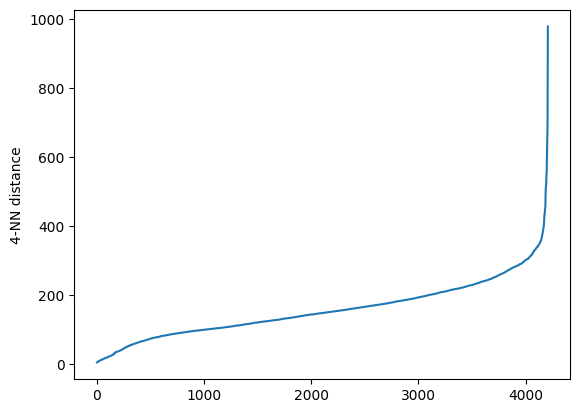

,class,tile,confidence,detection_id,geometry,rep_point,dbscan_label
0,0,BA31_1000_2939_2_0.jpg,0.881694,57c2397b-eaaf-4f48-b27d-297a4025a768,"POLYGON ((1750614.325 5925334.125, 1750614.325...",POINT (1750608.813 5925343.013),0
1,0,BA31_1000_2939_2_0.jpg,0.847962,c30b6c30-6f33-440c-9b61-f107658dad86,"POLYGON ((1750637.2 5925304.2, 1750637.2 59253...",POINT (1750632.775 5925307.313),0
2,0,BA31_1000_2939_2_1.jpg,0.814993,43c456f0-8f72-4122-b7ec-2316f1858f37,"POLYGON ((1750578.25 5925199.725, 1750578.25 5...",POINT (1750573.488 5925203.213),0
3,0,BA31_1000_2939_2_1.jpg,0.755062,98b2827e-0086-4f50-a606-640f4f25ef09,"POLYGON ((1750540.15 5925263.925, 1750540.15 5...",POINT (1750538.05 5925268.163),0
4,0,BA31_1000_2939_2_1.jpg,0.712368,0511a88e-1fcb-42d4-b845-99bb98b7e58c,"POLYGON ((1750606.825 5925173.175, 1750606.825...",POINT (1750601.725 5925176.663),0
...,...,...,...,...,...,...,...
4204,0,BA32_1000_4806_1_0.jpg,0.867234,a5ea365c-feac-4bf9-8129-38f86a86ef88,"POLYGON ((1758586.9 5912006.4, 1758586.9 59120...",POINT (1758578.538 5912011.275),67
4205,0,BA32_1000_4806_1_0.jpg,0.682668,6c09ac32-e8b3-4350-9174-055a985bda75,"POLYGON ((1758605.875 5912006.475, 1758605.875...",POINT (1758598 5912010.788),67
4206,0,BA32_1000_4806_1_1.jpg,0.860162,27278975-bb44-44d3-b61e-f2f4816e046c,"POLYGON ((1758586.975 5912006.1, 1758586.975 5...",POINT (1758578.538 5912011.012),67
4207,0,BA32_1000_4808_0_0.jpg,0.453647,a77e3773-4da4-40a7-97e6-09dca75d6766,"POLYGON ((1759511.575 5912124.375, 1759511.575...",POINT (1759508.125 5912125.575),-1


In [10]:
'''
DBSCAN clustering:
Must choose eps (meters). Use k-distance plot to find an elbow.
'''
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5).fit(coords)
distances, _ = neighbors.kneighbors(coords)
distances = np.sort(distances[:,4])  # 4th neighbor
plt.plot(distances); plt.ylabel('4-NN distance'); plt.show()
# pick eps at elbow
db = DBSCAN(eps=250, min_samples=5).fit(coords)
gdf_m['dbscan_label'] = db.labels_
gdf_m

In [ ]:
# gdf_m.to_file("detections.gpkg", layer="detections_dbscan", driver="GPKG")

ValueError: GeoDataFrame contains multiple geometry columns but GeoDataFrame.to_file supports only a single geometry column. Use a GeoDataFrame.to_parquet or GeoDataFrame.to_feather, drop additional geometry columns or convert them to a supported format like a well-known text (WKT) using `GeoSeries.to_wkt()`.

# Python alternatives:

pointpats from PySAL can compute some point-pattern stats, but spatstat is more complete.

* Aggregation + local spatial stats (Getis-Ord Gi*, Local Moran)
* Aggregate points to regular grid (square or hex). 

Square example:

In [7]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box

def make_grid(gdf, cell_size):
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xs = np.arange(xmin, xmax+cell_size, cell_size)
    ys = np.arange(ymin, ymax+cell_size, cell_size)
    polys = []
    for x in xs[:-1]:
        for y in ys[:-1]:
            polys.append(box(x, y, x+cell_size, y+cell_size))
    grid = gpd.GeoDataFrame({'geometry':polys}, crs=gdf.crs)
    return grid

grid = make_grid(gdf_m, cell_size=250)  # 250m grid
joined = gpd.sjoin(grid, gdf_m, how='left', predicate='contains')
counts = joined.groupby(joined.index).size()
grid['count'] = counts.reindex(grid.index).fillna(0)
grid
grid.to_file("detections.gpkg", layer="detections_grid_250m", driver="GPKG")

Compute Local Moran and Getis-Ord (PySAL)

In [ ]:
import libpysal
from esda import Moran_Local, G_Local

# centroids for spatial weights
centroids = np.vstack([grid.geometry.centroid.x, grid.geometry.centroid.y]).T
# w = libpysal.weights.DistanceBand.from_array(centroids, threshold=1500, binary=True, silence_warnings=True)
# or use KNN: 
w = libpysal.weights.KNN.from_array(centroids, k=8)

y = grid['count'].values
m_local = Moran_Local(y, w)
grid['moran_z'] = m_local.z_sim  # z scores
grid['moran_p'] = m_local.p_sim # p-values
grid['moran_cluster'] = m_local.q   # quadrant categories for LISA

# # Getis-Ord Gi* (local G)
# g_local = G_Local(y, w)
# grid['g_z'] = g_local.z_sim
# grid['g_p'] = g_local.p_sim
# grid['g_hotspot'] = g_local.Gs > 0  # hotspot if Gs > 0

In [ ]:
# grid['moran_z'].to_file("detections.gpkg", layer="detections_moran_local", driver="GPKG")   
# grid['moran_p'].to_file("detections.gpkg", layer="detections_moran_pvalues", driver="GPKG")
# grid['moran_cluster'].to_file("detections.gpkg", layer="detections_moran_clusters", driver="GPKG")
grid['moran_z']
grid['moran_p']
grid['moran_cluster']

0       1.185938
1       0.527986
2       0.089352
3      -0.307881
4       0.349795
          ...   
3115    1.131500
3116    1.131500
3117    0.927131
3118    0.518391
3119    0.314022
Name: moran_z, Length: 3120, dtype: float64

# Interpret Local Moran: 

high-high clusters, low-low clusters (q categories). Interpret Getis-Ord Gi*: high z = hotspot, low z = coldspot. Visualize in QGIS.

## Notes on weights and significance

* Choose neighbors or distance thresholds consistent with domain (e.g., 500m).

* Use permutation-based p-values (PySAL computes simulated p-values) to assess significance.

* Multiple testing: consider FDR correction if many cells tested.

# Point-pattern scale analysis — Ripley’s K / L
R/spatstat is easiest here. Example R outline:

In [ ]:
# Ripley K shows at what radii points are clustered / dispersed relative to CSR.

library(spatstat.geom)
library(spatstat.core)

# read points (from GeoPackage) into spatstat
library(sf)
pts = st_read("detections.gpkg", layer="detections")
pts_proj = st_transform(pts, 3857)
xy = st_coordinates(pts_proj)

# create point pattern in window (use study area bounding box)
W = owin(xrange=c(min(xy[,1]), max(xy[,1])), yrange=c(min(xy[,2]), max(xy[,2])))
pp = ppp(xy[,1], xy[,2], window=W)
K = Kest(pp, correction="border")
plot(K)
# use envelope to test against CSR
env = envelope(pp, Kest, nsim=99)
plot(env)